In [1]:
import numpy as np
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import warnings

#from scrapefork import *
from cleaning_functions import *
from create_pitchfork_lineups_data import *
from other_utils import *

In [2]:
warnings.simplefilter('ignore')

utils files:
1. scrapefork.py (borrowed)
2. scrape_pitchfork_reviews.py
3. scrape_pitchfork_features.py
4. create_pitchfork_lineups_data.py
5. cleaning_functions.py - all functions used too clean/munge/aggregate data for the model
6. other_utils.py - functions to print model performance metrics
    
data files:
1. data/raw_p4k_lineups.txt
2. data/pitchfork_reviews.csv
3. data/pitchfork_features_with_article_txt.csv

### new functions

In [3]:
def predict_by_top_probabilities(probability_preds, full_df):
    percent_true = full_df.played_fest.mean()
    number_true = pd.DataFrame(probability_preds)[1].shape[0] * percent_true
    true_prediction_cutoff = pd.DataFrame(probability_preds)[1].sort_values().tail(int(number_true)).min()

    reviews_preds_by_prob = (pd.DataFrame(probability_preds)[1] >= true_prediction_cutoff)
    return reviews_preds_by_prob

In [4]:
# import & clean datasets

# lineups
filepath = 'data/raw_p4k_lineups.txt'
lineups = get_lineups_data(filepath)

# reviews
reviews_df = pd.read_csv('data/pitchfork_reviews.csv')
reviews = clean_reviews_df(reviews_df)

# features
articles_df = pd.read_csv('data/pitchfork_features_with_article_txt.csv')
articles = clean_features_df(articles_df)

### first model - reviews

In [5]:
# first the reviews model
# formatting - 
reviews_cumul = gather_cumulative_review_data_by_artist(reviews)
reviews_cumul_final = add_review_features(reviews_cumul)
reviews_dfs = group_cumul_reviews_by_year(reviews_cumul_final)

# normalize numeric variables
reviews_full_df = join_year_dfs(reviews_dfs)

reviews_full_df['score_norm'] \
    = normalize_variable(reviews_full_df, 'score')
    
reviews_full_df['avg_cumul_score_norm'] \
    = normalize_variable(reviews_full_df, 'avg_cumul_score')

reviews_full_df['days_to_announcement_norm'] \
    = normalize_variable(reviews_full_df, 'days_to_announcement')

# interaction terms
reviews_full_df['score_x_days'] = reviews_full_df.score_norm  \
                    * reviews_full_df.days_to_announcement_norm
reviews_full_df['reissue_x_days'] = reviews_full_df.reissue \
                    * reviews_full_df.days_to_announcement_norm
reviews_full_df['cumul_score_x_days'] = reviews_full_df.avg_cumul_score_norm \
                    * reviews_full_df.days_to_announcement_norm
reviews_full_df['chicago_x_days'] = reviews_full_df.chicago_based \
                    * reviews_full_df.days_to_announcement_norm
reviews_full_df['performance_x_days'] = reviews_full_df.performance_mention \
                    * reviews_full_df.days_to_announcement_norm
reviews_full_df['best_x_days'] = reviews_full_df.best \
                    * reviews_full_df.days_to_announcement_norm
reviews_full_df['chicago_x_score'] = reviews_full_df.chicago_based \
                    * reviews_full_df.score_norm
reviews_full_df['performance_x_score'] = reviews_full_df.performance_mention \
                    * reviews_full_df.score_norm
reviews_full_df['chicago_x_performance'] = reviews_full_df.chicago_based \
                    * reviews_full_df.performance_mention


In [88]:
reviews_full_df_sample = reviews_full_df.sample(n=10000)

In [89]:
reviews_full_df_sample.shape

(10000, 38)

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', min_df=10)

X_reviews = tfidf_vectorizer.fit_transform(reviews_full_df_sample['review']) \
                            .toarray()

reviews_frequency_matrix = pd.DataFrame(X_reviews, columns 
                                = tfidf_vectorizer.get_feature_names())

#reviews_frequency_matrix = pd.read_csv('~/PycharmProjects/sklearn-testing/pitchfork_predictor/saved_features/reviews_frequency_matrix_mindf100.csv')


In [91]:
# no mindf
reviews_frequency_matrix.shape

(10000, 24628)

In [92]:
# mindf = 5
reviews_frequency_matrix.shape

(10000, 24628)

In [93]:
reviews_full_full_df = reviews_full_df_sample.reset_index(drop=True) \
                            .join(reviews_frequency_matrix, 
                                  rsuffix='_review')

In [94]:
reviews_model_df = join_lineups(reviews_full_full_df, lineups, 'left')
#reviews_model_df = join_lineups(reviews_full_df, lineups, 'left')

I started by training on all years 2005 - 2019 and using the 2020 lineup as the test set. 
Decided this was a bad idea, moved to using sklearn's train_test_split, but this was causing class imbalance between the train and test groups because of the already bad class imbalance inherent in the dataset.
Finally, moved to using sklearn's Stratified Shuffle Split which maintains the class ratio across groups

In [95]:
reviews_inputs = ['score_norm', 'avg_cumul_score_norm', 
                  'best', 'previous_reviews_count', 
                  'performance_mention', 'chicago_based', 'reissue',
                  'days_to_announcement_norm', 
                  'Rock', 'Rap', 'Jazz', 'Experimental', 'Pop/R&B',
                  'Electronic', 'Metal', 'Global', 'Folk/Country',
                  'score_x_days', 'reissue_x_days',
                  'cumul_score_x_days', 'chicago_x_days',
                  'performance_x_days', 'best_x_days',
                  'chicago_x_score', 'performance_x_score',
                  'chicago_x_performance'] \
                    + reviews_model_df.columns.tolist()[38:]

output = ['played_fest']

# 2020 as test group
#reviews_training_set = reviews_model_df.loc[
#                    reviews_model_df.fest_date != '2020-07-15'].reset_index(drop=True)
#reviews_test_set = reviews_model_df.loc[
#                    reviews_model_df.fest_date == '2020-07-15'].reset_index(drop=True)

#X_train = reviews_training_set[reviews_inputs]
#y_train = reviews_training_set[output].astype('int')
#X_test = reviews_test_set[reviews_inputs]
#y_test = reviews_test_set[output].astype('int')

# sklearn train test split
#X_train, X_test, y_train, y_test \
#        = train_test_split(reviews_model_df[reviews_inputs], 
#                           reviews_model_df[output], test_size=0.33, random_state=42)

# best solution so far - using stratified shuffle split
from sklearn.model_selection import StratifiedShuffleSplit

X = reviews_model_df[reviews_inputs]
y = reviews_model_df[output]

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.33, random_state=42)
sss.split(X, y)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = pd.DataFrame(np.asarray(X)[train_index], columns = reviews_inputs), \
                            pd.DataFrame(np.asarray(X)[test_index], columns = reviews_inputs)
    y_train, y_test = pd.DataFrame(np.asarray(y)[train_index], columns = output), \
                            pd.DataFrame(np.asarray(y)[test_index], columns = output)

In [96]:
# sss maintains class ratio
print(f'share of trues in full df: {reviews_model_df.played_fest.mean().round(5)}')
print(f'share of trues in training set: {y_train.played_fest.mean().round(5)}')
print(f'share of trues in test set: {y_test.played_fest.mean().round(5)}')

share of trues in full df: 0.0068
share of trues in training set: 0.00687
share of trues in test set: 0.00667


In [97]:
from sklearn.ensemble import RandomForestClassifier

reviews_model = RandomForestClassifier()
reviews_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [98]:
# performance LOL
from sklearn.metrics import f1_score, accuracy_score, precision_score, \
                            recall_score, confusion_matrix

reviews_preds = reviews_model.predict(X_test)
reviews_prob_preds = reviews_model.predict_proba(X_test)
print_performance_metrics(y_test, reviews_preds)

f1:  0.0
accuracy:  0.993
precision:  0.0
recall:  0.0
              predicted false  predicted true
actual false             3276               2
actual true                22               0


In [99]:
reviews_preds_by_prob = predict_by_top_probabilities(reviews_prob_preds, reviews_model_df)
print_performance_metrics(y_test, reviews_preds_by_prob)

f1:  0.913
accuracy:  0.999
precision:  0.875
recall:  0.955
              predicted false  predicted true
actual false             3275               3
actual true                 1              21


In [100]:
reviews_training_preds = reviews_model.predict(X_train)
reviews_training_prob_preds = reviews_model.predict_proba(X_train)
print_performance_metrics(y_train, reviews_training_preds)

f1:  1.0
accuracy:  1.0
precision:  1.0
recall:  1.0
              predicted false  predicted true
actual false             6654               0
actual true                 0              46


In [101]:
reviews_training_preds_by_prob = predict_by_top_probabilities(reviews_training_prob_preds, reviews_model_df)
print_performance_metrics(y_train, reviews_training_preds_by_prob)

f1:  0.989
accuracy:  1.0
precision:  1.0
recall:  0.978
              predicted false  predicted true
actual false             6654               0
actual true                 1              45


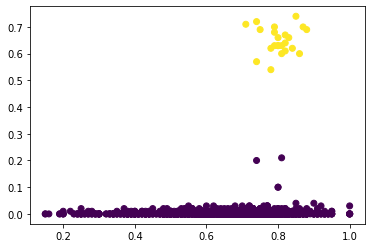

In [60]:
x = X_train.score_norm
y = pd.DataFrame(reviews_training_prob_preds)[1]
plt.scatter(x, y, c=y_train.played_fest)

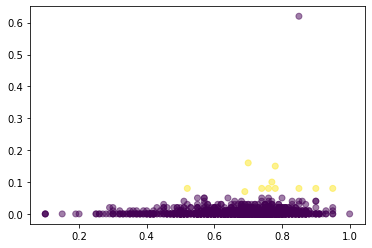

In [61]:
x = X_test.score_norm
y = pd.DataFrame(reviews_prob_preds)[1]
plt.scatter(x, y, c=y_test.played_fest, alpha=.5)

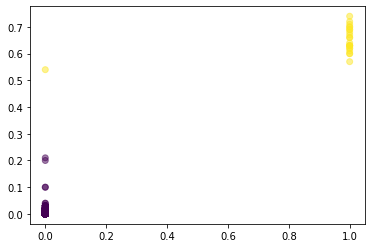

In [62]:
x = reviews_training_preds_by_prob
y = pd.DataFrame(reviews_training_prob_preds)[1]
plt.scatter(x, y, c=y_train.played_fest, alpha = .5)

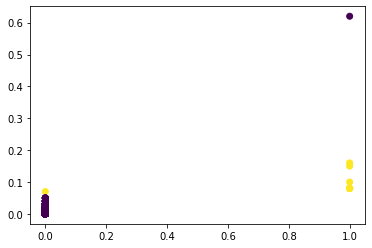

In [63]:
x = reviews_preds_by_prob
y = pd.DataFrame(reviews_prob_preds)[1]
plt.scatter(x, y, c=y_test.played_fest)


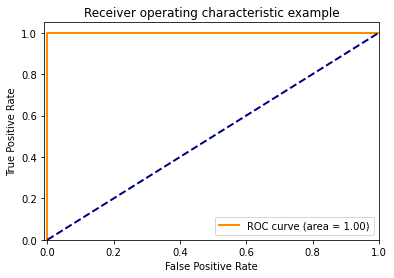

In [86]:
# training
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train, pd.DataFrame(reviews_training_prob_preds)[1])

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#print thresholds.shape
#plt.scatter(fpr, tpr)
#for i, txt in enumerate(thresholds):
#    plt.annotate(' ' + str(txt), (fpr[i], tpr[i]))
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

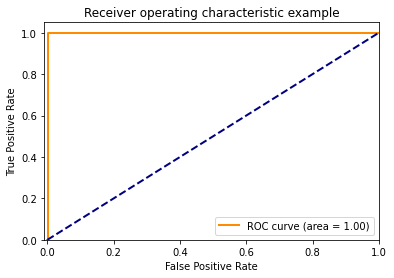

In [87]:
# test
fpr, tpr, thresholds = roc_curve(y_test, pd.DataFrame(reviews_prob_preds)[1])

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#print thresholds.shape
#plt.scatter(fpr, tpr)
#for i, txt in enumerate(thresholds):
#    plt.annotate(' ' + str(txt), (fpr[i], tpr[i]))
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# trying out grid search to tune model
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

reviews_model = RandomForestClassifier()

parameters = {'max_depth':[10, 12, 15],
              'n_estimators':[100, 200],
              'min_samples_split':[6, 8],
              'min_samples_leaf':[2, 4, 6]}

scorer = make_scorer(f1_score)
grid_obj = GridSearchCV(reviews_model, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)

best_reviews_model = grid_fit.best_estimator_
best_reviews_model.fit(X_train, y_train)

best_train_predictions = best_reviews_model.predict(X_train)
best_test_predictions = best_reviews_model.predict(X_test)

print('training f1: ', f1_score(best_train_predictions, y_train))
print('test f1: ', f1_score(best_test_predictions, y_test))

best_reviews_model

In [ ]:
# performance on test set
reviews_preds = best_reviews_model.predict(X_test)
reviews_prob_preds = best_reviews_model.predict_proba(X_test)

print_performance_metrics(y_test, reviews_preds)

In [ ]:
# performance on training set
reviews_training_preds = best_reviews_model.predict(X_train)
reviews_training_prob_preds = best_reviews_model.predict_proba(X_train)

print_performance_metrics(y_train, 
                          reviews_training_preds)

In [59]:
# look at feature importances
pd.DataFrame(zip(reviews_inputs, reviews_model.feature_importances_)).sort_values(1, ascending=False).head(30)

,0,1
25658,played_fest,0.034036
7,days_to_announcement_norm,0.015165
19,cumul_score_x_days,0.013175
17,score_x_days,0.011861
25657,played_previous_fest,0.010016
269,96,0.004170
4359,collegiate,0.004120
17950,rae,0.003984
11737,instinctual,0.003882
8001,execute,0.003844


In [32]:
reviews_model_df.head()#loc[reviews_model_df.review.str.contains('flooded')]

,artist_clean,fest_date,artist_review,album_review,score_review,genre_review,review_review,best_review,date_clean,previous_reviews_count,...,zé,âme,élan,ólöf,öyster,øye,über,รก,played_previous_fest,played_fest
0,hood,2012-07-15,Hood,Recollected,8.5,Rock,"Best new reissue Since 1990, the Leeds, Englan...",1,2012-02-24,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
1,jürgen paape,2013-07-15,Jürgen Paape,Kompilation,7.9,Electronic,"Despite a lack of prolificness, Kompakt co-fou...",0,2011-01-05,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
2,a weather,2012-07-15,A Weather,Everyday Balloons,7.0,Rock,Portland band effectively translates its once-...,0,2010-03-24,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
3,black tusk,2019-07-15,Black Tusk,Pillars of Ash,8.2,Metal,The Savannah sludge metal band Black Tusk's fi...,0,2016-02-02,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
4,noveller,2018-07-15,Noveller,A Pink Sunset For No One,6.5,Rock,This is Sarah Lipstate’s biggest record as Nov...,0,2017-02-18,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False


### second model - articles

In [ ]:
# now the articles model
# formatting - 
articles_dfs = group_articles_by_year(articles)

# join into full df
articles_full_df = join_year_dfs(articles_dfs)
# normalize date var
articles_full_df['days_to_announcement_norm'] \
    = normalize_variable(articles_full_df, 'days_to_announcement')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')

X_article = tfidf_vectorizer.fit_transform(articles_full_df['article']).toarray()

articles_frequency_matrix = pd.DataFrame(X_article, columns 
                                = tfidf_vectorizer.get_feature_names())

In [ ]:
articles_full_full_df = articles_full_df.reset_index(drop=True) \
                    .join(articles_frequency_matrix, lsuffix='_article')

In [ ]:
# join y col
articles_model_df = join_lineups(articles_full_full_df, 
                                 lineups, 'left')

In [ ]:
# train articles sub-model
articles_training_set = articles_model_df.loc[
                        articles_model_df.fest_date != '2020-07-15']
articles_test_set = articles_model_df.loc[
                        articles_model_df.fest_date == '2020-07-15']

articles_inputs = ['days_to_announcement_norm', 'artist_count',
                   'Interview', 'Moodboard', 'Rising', 'Song by Song',
                   '5-10-15-20', 'Longform', 'Profile', 'Lists & Guides', 
                   'Photo Gallery', 'Podcast', 'Family Matters', 
                   'Overtones', 'Festival Report', 'Cover Story',
                   'Afterword', 'Situation Critical', 'Director\'s Cut'] \
                    + tfidf_vectorizer.get_feature_names()

output = ['played_fest']

In [ ]:
X_train = articles_training_set[articles_inputs]
y_train = articles_training_set[output].astype('int')
X_test = articles_test_set[articles_inputs]
y_test = articles_test_set[output].astype('int')

articles_model = RandomForestClassifier()
articles_model.fit(X_train, y_train)

In [ ]:
# basic performance
articles_preds = articles_model.predict(X_test)
print_performance_metrics(y_test, articles_preds)

In [ ]:
# basic performance on training
articles_training_preds = articles_model.predict(X_train)
print_performance_metrics(y_train, articles_training_preds)

In [ ]:
article_feature_importances = pd.DataFrame(
    zip(articles_inputs, articles_model.feature_importances_)
            )

In [ ]:
article_feature_importances.sort_values(1, ascending=False)

### output probability predictions from first layer

In [ ]:
# output dataframes for next model layer
reviews_layer_output = format_next_layer_df(reviews_model_df,
                                            reviews_model,
                                            reviews_inputs)

articles_layer_output = format_next_layer_df(articles_model_df,
                                             articles_model,
                                             articles_inputs)

In [ ]:
# then join them together & join in lineups
model_df = reviews_layer_output \
                .set_index(['artist_clean', 'fest_date']) \
            .join(articles_layer_output
                      .set_index(['artist_clean', 'fest_date']),
                  how = 'outer', lsuffix = '_reviews',
                  rsuffix = '_articles').reset_index()

full_model_df = join_lineups(model_df, lineups, 'outer')
full_model_df.fillna(0, inplace=True)

In [ ]:
full_model_df['review_x_article'] = full_model_df.prob_reviews \
                                        * full_model_df.prob_articles

### final model

In [ ]:
training_set = full_model_df.loc[
                    full_model_df.fest_date != '2020-07-15']
test_set = full_model_df.loc[
                    full_model_df.fest_date == '2020-07-15']

inputs = ['prob_reviews', 'prob_articles', 'played_previous_fest', 
          'review_x_article']
ycol = ['played_fest']

In [ ]:
full_model = RandomForestClassifier()
full_model.fit(training_set[inputs], training_set[ycol])

In [ ]:
preds = full_model.predict(test_set[inputs])
prob_preds = full_model.predict_proba(test_set[inputs])

In [ ]:
print_performance_metrics(test_set[ycol], preds)

#### lol

In [ ]:
training_preds = full_model.predict(training_set[inputs])
training_preds_prob = full_model.predict_proba(training_set[inputs])

In [ ]:
print_performance_metrics(training_set[ycol], training_preds)

In [ ]:
results = training_set.reset_index() \
                .join(pd.DataFrame(training_preds_prob)[1]) \
                .join(pd.DataFrame(training_preds)) \
                .sort_values(1, ascending=False)

In [ ]:
results.groupby(round(results['prob_articles'], 1)).agg({
    'played_fest':'mean', 0:'mean', 'artist_clean':'count'
})

In [ ]:
pd.DataFrame(zip(inputs, full_model.feature_importances_))

In [ ]:
training_set.shape

In [ ]:
test_set.shape